The goal of this notebook is to present U-net implementation in order to perform cell semantic segmentation on sartorius kaggle dataset. 

# Configuration

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from termcolor import colored

In [2]:
class config:
    DIRECTORY_PATH = "../input/sartorius-cell-instance-segmentation"
    TRAIN_CSV = DIRECTORY_PATH + "/train.csv"
    TRAIN_PATH = DIRECTORY_PATH + "/train"
    TEST_PATH = DIRECTORY_PATH + "/test"
    TRAIN_SEMI_SUPERVISED_PATH = DIRECTORY_PATH + "/train_semi_supervised"

In [3]:
def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirpath, dirnames, filenames in os.walk(path):
        #for filename in tqdm(filenames): #to show progress bar, needs tqdm library
        for filename in filenames:
            fullpath = os.path.join(dirpath, filename)
            image_names.append(fullpath)
    return image_names

In [4]:
#Get complete image paths for train and test datasets
train_images_path = getImagePaths(config.TRAIN_PATH)
test_images_path = getImagePaths(config.TEST_PATH)
train_semi_supervised_path = getImagePaths(config.TRAIN_SEMI_SUPERVISED_PATH)

* # First step : Get info from the dataset

## 1. General information

In [5]:
df_train = pd.read_csv(config.TRAIN_CSV)
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


In [7]:
for col in df_train.columns:
    print(col + ":" + colored(str(len(df_train[col].unique())), 'blue'))

id:606
annotation:73470
width:1
height:1
cell_type:3
plate_time:8
sample_date:18
sample_id:403
elapsed_timedelta:8


In [8]:
print(f"Number of train images: {colored(len(train_images_path), 'blue')}")
print(f"Number of test images:  {colored(len(test_images_path), 'blue')}")

Number of train images: 606
Number of test images:  3


## 2. Cells Distribution

In [9]:
def plot_distribution(x):

    fig = sns.histplot(
    df_train, 
    x = x
    )


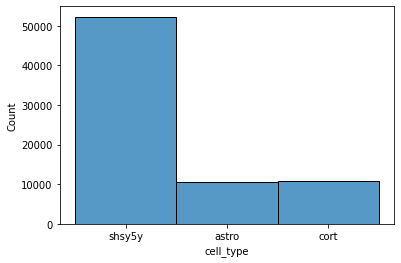

In [10]:
plot_distribution('cell_type')

## 3. Images sorting and display

In [11]:
train_images_path_sorted = np.sort(train_images_path)

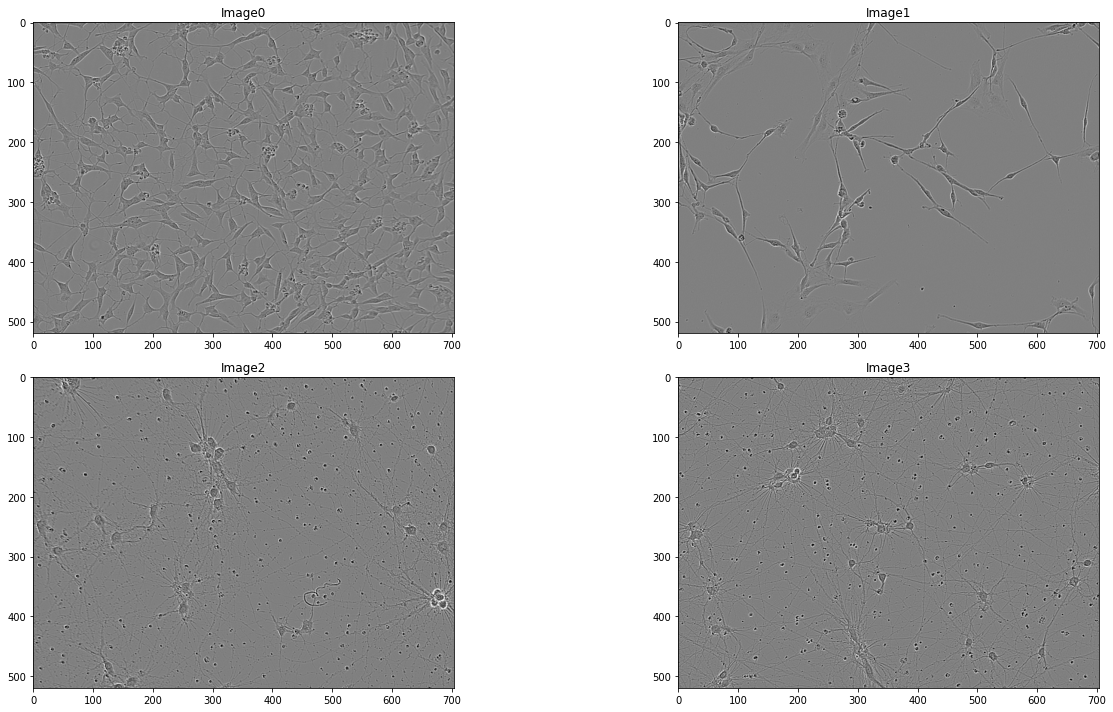

In [12]:
def display_multiple_img(images_path, rows, cols):

    axes=[]
    fig=plt.figure()
    
    for i in range(rows*cols):
        img = cv2.imread(images_path[i])
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image"+str(i))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img)
        
    fig.set_figwidth(20)
    fig.set_figheight(10)

    fig.tight_layout()  

    plt.show()
    
display_multiple_img(train_images_path_sorted[0:4], 2, 2)

* # Second step : Create and display the training segmentation masks

In [13]:
def create_mask_array(height,width,annotations,color = 1):
    
    # Initialisation of empty image
    mask_array = np.zeros((height,width), np.uint8)
    
    # Work on all annotation files for one image id
    for i in range(len(annotations)):
    
        # Creation of masks from annotations
        annotation_split = list(annotations[i].split())
        annotation_int = list(map(int,annotation_split))
        
        for k in range(len(annotation_int)):
        # To account for line break
            if k % 2 == 0:
                # add minus 1 otherwise issue with image named "b2a7f3d06a50" of index 430, there must be a mismatch with 
                # the annotations beginning at 1 and not 0...
                column = (annotation_int[k]-1) // height 
                raw = (annotation_int[k]-1) % height

                mask_array[raw:(raw+annotation_int[k+1]),column] = color
                mask_array = mask_array.clip(0, 1) # To delete overlaps between annotations
    
    mask_array = np.flip(mask_array)
    #to mirror along 2nd axis
    mask_array = mask_array[...,::-1,:]
    return np.rot90(mask_array)

def create_mask_image(mask_array,color=1):
    
    height = np.shape(mask_array)[0]
    width = np.shape(mask_array)[1]
    mask_image = np.zeros((height,width,3), np.uint8)
    
    mask_image[mask_array==1] = [0,0,255]     # (R, G, B)
    
    # To vizualize the mask
    #plt.imshow(mask_image*255)
    
    # To get the array corresponding to the mask
    return(mask_image)
    
annotations = df_train[df_train.id == '0030fd0e6378']['annotation'].tolist()
mask_array = create_mask_array(704,520,annotations)
mask_image = create_mask_image(mask_array,color=1)  

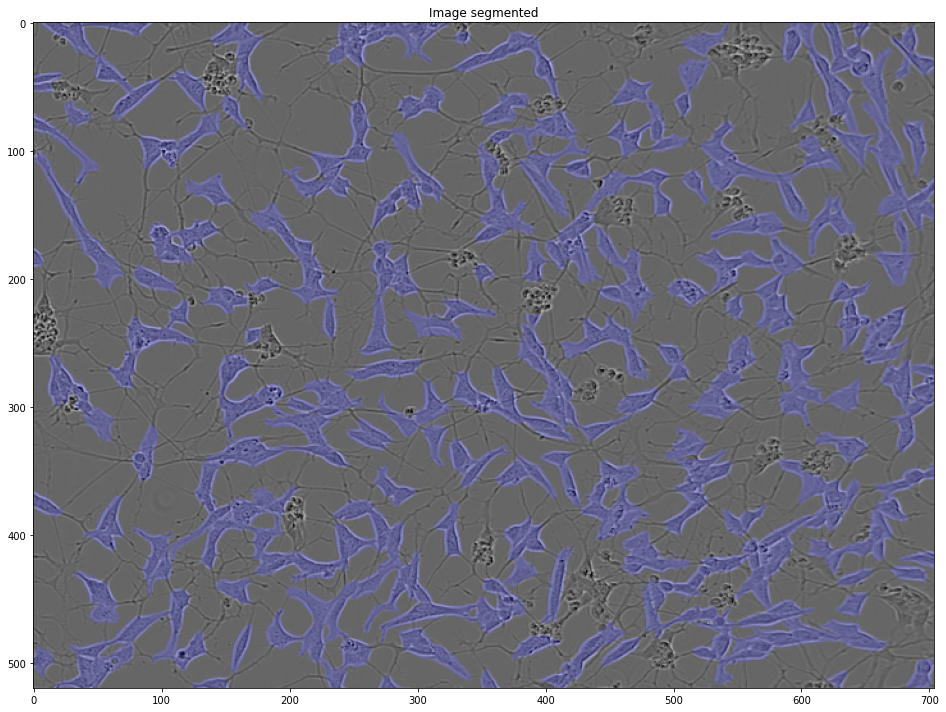

In [14]:
def create_overlay_image_mask(img,mask_image):
    image = cv2.imread(img)
    
    #transparency
    alpha = 0.2
    beta = 1 - alpha
    
    overlay_output = cv2.addWeighted(mask_image ,alpha, image,beta, 0.0)
    
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    
    plt.imshow(overlay_output)
    plt.title("Image segmented")
    fig.tight_layout()  
    plt.show()
    
create_overlay_image_mask(train_images_path_sorted[0],mask_image)

* # Third step : Training neural network

## 0. Constants

In [15]:
SEED = 1
TARGET_SIZE = (512,512)
LEARNING_RATE = 1e-3

## 1. U-Net Architecture

![U-net Neural Network architecture](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png)

From https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

The network can be seen as succession of mini-encoders and mini-decoders (respectively on the left and right parts of the figure).

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K

In [17]:
def conv_block(input, num_filters, kernel_size = 3):
    x = Conv2D(num_filters, kernel_size = kernel_size, padding="same")(input)
    x = BatchNormalization()(x) #to help stabilize the model 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, kernel_size = kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [18]:
def mini_encoder_block(input,num_filters):
    x = conv_block(input, num_filters, kernel_size = 3)
    p = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
    return x,p #needs 2 outputs (one after max pooling, and one after 2 convolutions to copy and crop)

In [19]:
def mini_decoder_block(input,mini_encoder_features,num_filters):
    x = Conv2DTranspose(num_filters, kernel_size = 2, strides=2, padding="same")(input)
    #strides = 2 has the same effect of a deconvolution of factor 2
    x = Concatenate()([x, mini_encoder_features])
    x = conv_block(x, num_filters, kernel_size = 3)
    return x

In [20]:
def u_net(input_size=(512,512,3)):

    inputs = Input(input_size)
    
    e1,p1 = mini_encoder_block(inputs,64)
    e2,p2 = mini_encoder_block(p1,128)
    e3,p3 = mini_encoder_block(p2,256)
    e4,p4 = mini_encoder_block(p3,512)
    
    e5 = conv_block(p4, 1024, kernel_size = 3)
    
    d1 = mini_decoder_block(e5,e4,512)
    d2 = mini_decoder_block(d1,e3,256)
    d3 = mini_decoder_block(d2,e2,128)
    d4 = mini_decoder_block(d3,e1,64)
    
    #1 class of mask for semantic segmentation and output channel with sigmoid activation function
    outputs = Conv2D(1, kernel_size = 1, padding="same", activation="sigmoid")(d4)
    
    #3 classes of mask for instance segmentation and output channel with softmax activation function
    #outputs = Conv2D(3, kernel_size = 1, padding="same", activation="softmax")(d4)

    model = Model(inputs=inputs, outputs=outputs, name = "U_Net")
    return model

model = u_net(input_size=(512,512,3))
model.summary()

2022-01-10 17:14:33.325885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:14:33.422434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:14:33.423428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 17:14:33.426221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "U_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 2. Dataset for training

In [21]:
# images

input_images = np.zeros(606,dtype=object) #to be filled by arrays

for i,im in enumerate(train_images_path_sorted): 
    
    ''' 
    Preparation of images for U-net : 
    - resize (512,512)
    - normalize ([0,1])
    '''
    
    img = cv2.imread(im)
    img = cv2.resize(img, TARGET_SIZE, interpolation = cv2.INTER_NEAREST)
    img_norm = img/255
    input_images[i] = img_norm

In [22]:
#masks

train_annotations = np.zeros(606,dtype=object)
input_masks = np.zeros(606,dtype=object)
input_masks_images = np.zeros(606,dtype=object)

for i,image_id in enumerate(df_train.id.unique()):
    
    train_annotations[i] = df_train[df_train.id == image_id]['annotation'].tolist()
    mask_array = create_mask_array(704,520,train_annotations[i])
    input_masks[i] = cv2.resize(mask_array, TARGET_SIZE, interpolation = cv2.INTER_NEAREST)
    input_masks_images[i] = create_mask_image(input_masks[i],color=1)  
    

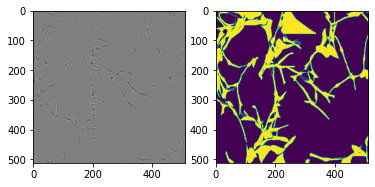

In [23]:
# To check that masks are correct for corresponding images

image_indx = 1

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(input_images[image_indx])

fig.add_subplot(1,2,2)
plt.imshow(input_masks[image_indx])

plt.show()

In [24]:
from sklearn.model_selection import train_test_split

split = train_test_split(input_images, input_masks, test_size=0.2)

# unpack the data split
(trainImages, validationImages) = split[:2]
(trainMasks, validationMasks) = split[2:]

'''
Mandatory step before using ImageDataGenerator
'''
# RGB colors
trainImages_reshape = [im.reshape(1, 512, 512, 3) for im in trainImages]
validationImages_reshape = [im.reshape(1, 512, 512, 3) for im in validationImages]
# Greyscale
trainMasks_reshape = [im.reshape(1, 512, 512, 1) for im in trainMasks]
validationMasks_reshape = [im.reshape(1, 512, 512, 1) for im in validationMasks]


## 3. Data augmentation

To transform images and masks together, to avoid overfitting. 

From https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''
This generator of augmented data applies transformations (augmentations) to both images and masks at the same time,
which is primordial for this project concerning segmentation. 

The generator works with a parameter **aug_dict which will vary depending on if the generator is applied to:
- training data 
- validation data
'''

def generator(Images, Masks, batch_size, aug_dict, target_size=TARGET_SIZE, seed=SEED):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow(x=Images, y=None, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(x=Masks, y=None, batch_size=batch_size, seed=seed)
    
    
    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        #allows to get augmented images from original images (np.array(img[1]),np.array(mask[1]))
        #yield function allows to return one by one couple without keeping it in memory after next method.
        yield (np.array(img[0]).reshape(1, 512, 512, 3) ,np.array(mask[0]).reshape(1, 512, 512, 1)) 
    

'''
Goal is to use aug_dict = train_generator_args for training data
'''

train_generator_args = dict(rotation_range=90,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

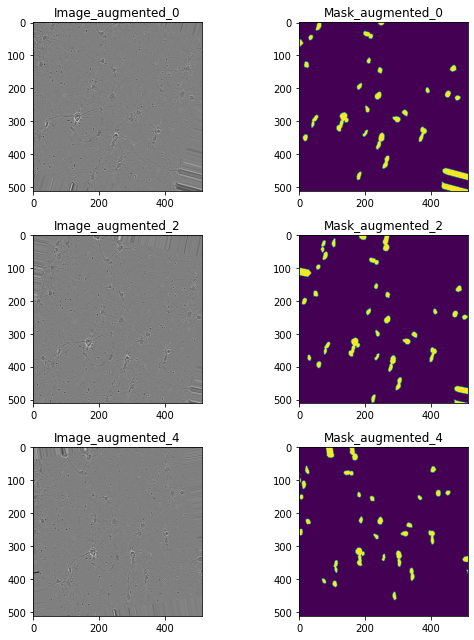

In [26]:
def plot_augmentation(generator, n_rows=3, n_cols=2):

    axes=[]
    fig=plt.figure(figsize=(n_cols*4, n_rows*3))

    for i in range(0,n_rows*n_cols,2):
        
        transfo = next(full_generator)
        # To plot numpy arrays from 0 to 255 and not tensors from 0 to 1
        image = (transfo[0]*255).reshape(512, 512, 3)
        mask = (transfo[1]*255).reshape(512, 512, 1)
        
        axes.append( fig.add_subplot(n_rows, n_cols, i+1) )
        subplot_title=("Image_augmented_"+str(i))
        axes[-1].set_title(subplot_title)  
        # needs to convert float array back to int images
        image = np.array(image, dtype='int')
        plt.imshow(image)
        
        axes.append( fig.add_subplot(n_rows, n_cols, i+2) )
        subplot_title=("Mask_augmented_"+str(i))
        axes[-1].set_title(subplot_title)  
        plt.imshow(mask)
        
    fig.tight_layout()    
    plt.show()
      
full_generator = generator(trainImages_reshape, trainMasks_reshape, 32, 
                           train_generator_args, target_size=TARGET_SIZE, seed=SEED)
plot_augmentation(full_generator)

## 4. Loss function and metrics

The Intersection over Union ratio is used for the challenge. Jaccard index (Jaccard similarity coefficient), which is defined as the size of the intersection divided by the size of the union of two label sets, is used. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html)

Here I will use it firstly on 1 class (in mask or not) but final version should include mutli-class as there are 3 possible classes of masks for cells. However, as my goal was really to implement and use U-net neural network, I will first look at the single class results as U-net is normally used for semantic segmentation (1 class) and not instance segmentation (several classes). 

![Difference between segmentation tasks](https://learnopencv.com/wp-content/uploads/2021/05/semseg-vs-instseg-768x350.jpg)

After reading papers on U_net applied to biomedical images segmentation 
(For example: https://towardsdatascience.com/biomedical-image-segmentation-unet-991d075a3a4b
and https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras), I decided to use common metrics and losses for such project involving U-net.

Dice score is equivalent to (F1 score) and Intersection over Union score is equivalent to (Jaccard score). (for the implementations in scikitlearn)

In [27]:
# Part inspired by https://towardsdatascience.com/biomedical-image-segmentation-unet-991d075a3a4b

smooth=1 #to avoid division by zero

#intersection over total area (both predict and ground truth)
def dice_coef(y_true, y_pred):
    y_true_flat=K.flatten(y_true)
    y_pred_flat=K.flatten(y_pred)
    pos_correct=K.sum(y_true_flat* y_pred_flat) #because 0 and 1
    return((2* pos_correct + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth))

####
#t1 = tf.constant([[[1, 0.5, 1], [1, 0.9, 0.7], [0.3, 0, 0]]], dtype=float)
#t2 = tf.constant([[[1, 0, 1], [1, 1, 1], [0, 0, 0]]], dtype=float)
#dice_coef(t1, t2)
###

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#intersection over union 
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    return (intersection + smooth) / (sum_ - intersection + smooth)

def jac_distance(y_true, y_pred):
    return 1-iou(y_true, y_pred)


## 5. Training

#### 5.1 Data Augmentation 

In [28]:
train_gen = generator(Images=trainImages_reshape, Masks=trainMasks_reshape, 
                      batch_size=32, aug_dict=train_generator_args)

#No data augmentation for the validation part
validation_gen = generator(Images=validationImages_reshape, Masks=validationMasks_reshape, 
                           batch_size=8, aug_dict=dict())

#### 5.2 Model compiling, fitting and evaluating

In [29]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

model = u_net(input_size=(512,512,3))

decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks=[LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 100), verbose=1)]
#callbacks=[EarlyStopping(monitor="val_loss", patience = 3)]

history = model.fit(train_gen,
                    steps_per_epoch=len(trainImages) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = validation_gen,
                    validation_steps=len(validationImages) / BATCH_SIZE)

2022-01-10 17:16:16.222850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.


2022-01-10 17:16:19.079896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15/15 [==============================] - 13s 200ms/step - loss: 0.8708 - binary_accuracy: 0.6266 - iou: 0.0692 - dice_coef: 0.1292 - val_loss: 0.9103 - val_binary_accuracy: 0.0565 - val_iou: 0.0470 - val_dice_coef: 0.0897
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.00010232929922807541.
15/15 [==============================] - 3s 182ms/step - loss: 0.8161 - binary_accuracy: 0.7945 - iou: 0.1014 - dice_coef: 0.1839 - val_loss: 0.9114 - val_binary_accuracy: 0.9510 - val_iou: 0.0464 - val_dice_coef: 0.0886
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.00010471285480508996.
15/15 [==============================] - 3s 174ms/step - loss: 0.7807 - binary_accuracy: 0.8606 - iou: 0.1232 - dice_coef: 0.2193 - val_loss: 0.9137 - val_binary_accuracy: 0.9510 - val_iou: 0.0451 - val_dice_coef: 0.0863
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.00010715193052376064.
15/15 [==============================] - 3s 1

This part dedicated to find the optimal learning rate is highly inspired by the work of:
https://towardsdatascience.com/how-to-optimize-learning-rate-with-tensorflow-its-easier-than-you-think-164f980a7c7b

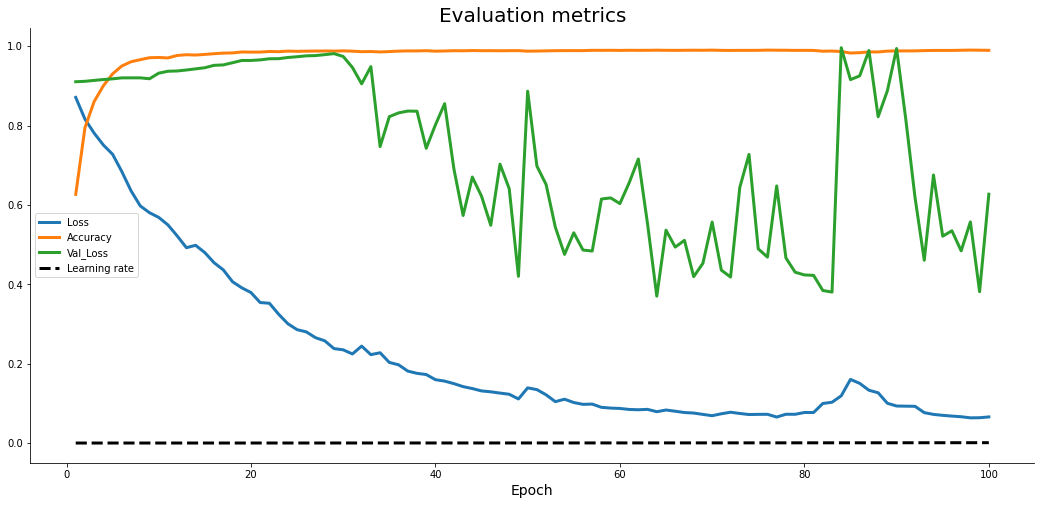

In [30]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, EPOCHS+1), 
    history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, EPOCHS+1), 
    history.history['binary_accuracy'], 
    label='Accuracy', lw=3
)

plt.plot(
    np.arange(1, EPOCHS+1), 
    history.history['val_loss'], 
    label='Val_Loss', lw=3
)

plt.plot(
    np.arange(1, EPOCHS+1), 
    history.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

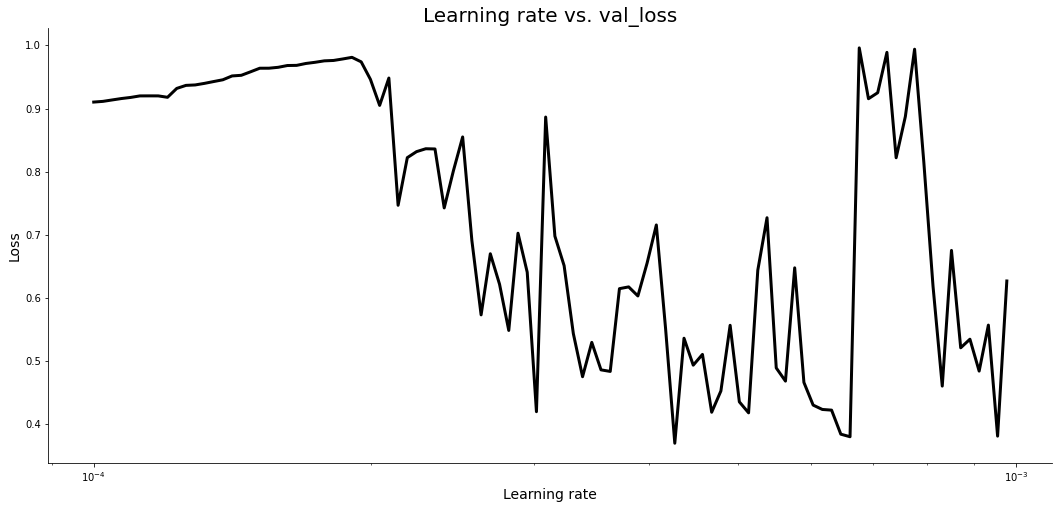

In [31]:
learning_rates = 1e-4 * (10 ** (np.arange(100) / 100))
plt.semilogx(
    learning_rates, 
    history.history['val_loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. val_loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);

From the precedent observation, one can see that the optimal learning rate is about learning_rate = 0.0002. 

Moreover, a number of 40 epochs seems to give the best results (we could place a EarlyStopping callbacks to confirm this thought). 

Let's try to fit the model with these newly optimal learning rate and epochs number. 

In [32]:
# work on lr and epoch for validation

EPOCHS = 40 
learning_rate=0.0002


model_opt = u_net(input_size=(512,512,3))

decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_opt.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

history_opt = model_opt.fit(train_gen,
                            steps_per_epoch=len(trainImages) / BATCH_SIZE, 
                            epochs=EPOCHS, 
                            validation_data = validation_gen,
                            validation_steps=len(validationImages) / BATCH_SIZE)

Epoch 1/40
15/15 [==============================] - 5s 199ms/step - loss: 0.8415 - binary_accuracy: 0.7239 - iou: 0.0865 - dice_coef: 0.1585 - val_loss: 0.9094 - val_binary_accuracy: 0.0491 - val_iou: 0.0475 - val_dice_coef: 0.0906
Epoch 2/40
15/15 [==============================] - 3s 177ms/step - loss: 0.7748 - binary_accuracy: 0.8754 - iou: 0.1270 - dice_coef: 0.2252 - val_loss: 0.9128 - val_binary_accuracy: 0.9510 - val_iou: 0.0456 - val_dice_coef: 0.0872
Epoch 3/40
15/15 [==============================] - 3s 169ms/step - loss: 0.7081 - binary_accuracy: 0.9321 - iou: 0.1712 - dice_coef: 0.2919 - val_loss: 0.9182 - val_binary_accuracy: 0.9510 - val_iou: 0.0427 - val_dice_coef: 0.0818
Epoch 4/40
15/15 [==============================] - 3s 169ms/step - loss: 0.6490 - binary_accuracy: 0.9573 - iou: 0.2131 - dice_coef: 0.3510 - val_loss: 0.9110 - val_binary_accuracy: 0.0637 - val_iou: 0.0466 - val_dice_coef: 0.0890
Epoch 5/40
15/15 [==============================] - 3s 169ms/step - loss

## 6. Results

In [33]:
validation_gen = generator(Images=validationImages_reshape, Masks=validationMasks_reshape, 
                           batch_size=8, aug_dict=dict())

results = model_opt.evaluate(validation_gen, steps=len(validationImages)/8)

print("Validation dice coeff loss: ",results[0])
print("Validation binary accuracy: ",results[1])
print("Validation IOU: ",results[2])
print("Validation dice coeff: ",results[3])

15/15 [==============================] - 1s 48ms/step - loss: 0.8115 - binary_accuracy: 0.9557 - iou: 0.1041 - dice_coef: 0.1885
Validation dice coeff loss:  0.8114699721336365
Validation binary accuracy:  0.95574951171875
Validation IOU:  0.10410773009061813
Validation dice coeff:  0.18853013217449188


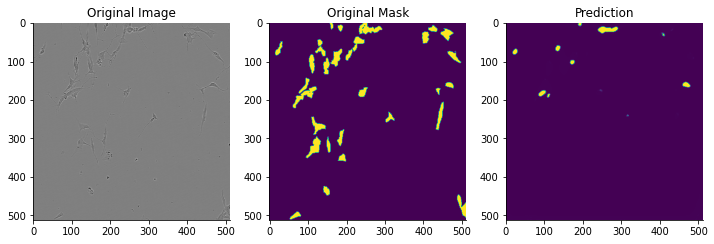

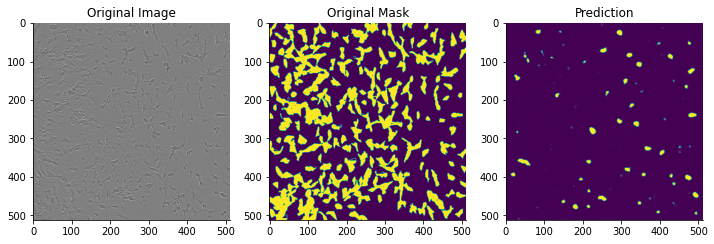

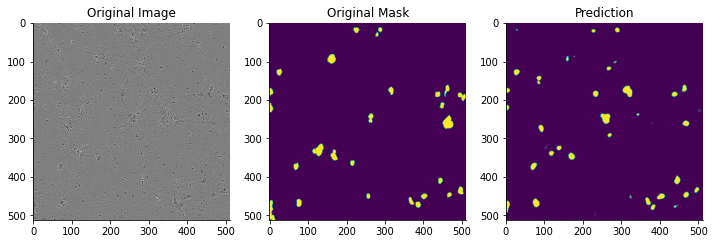

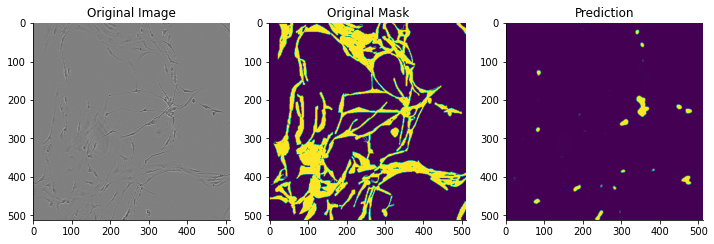

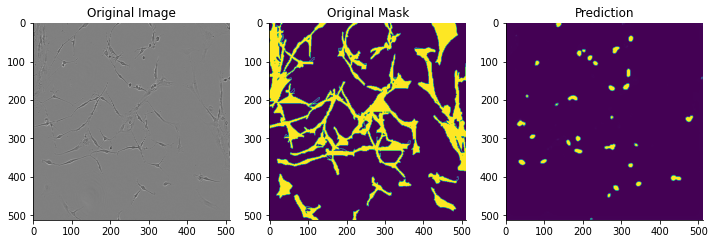

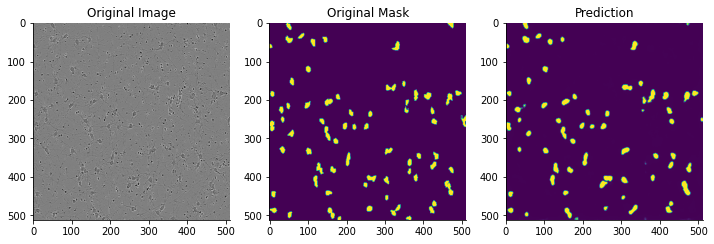

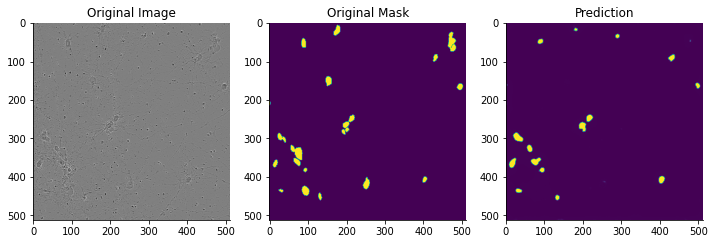

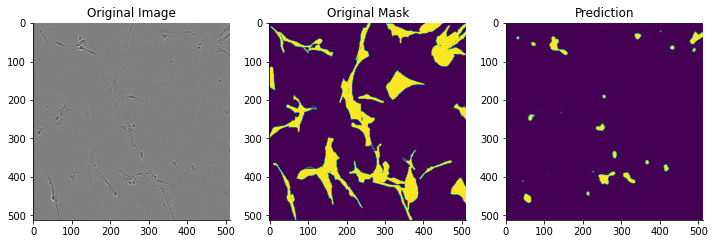

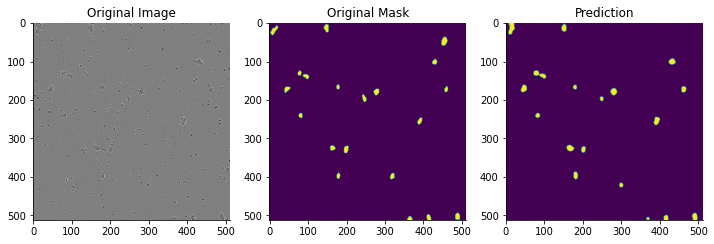

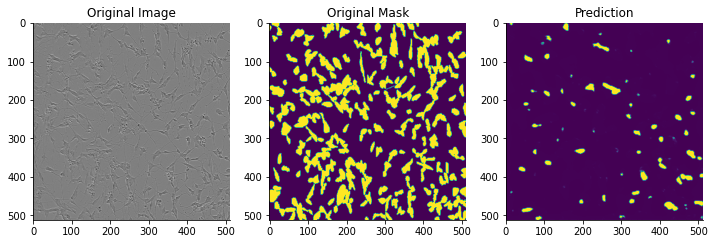

In [34]:
for i in range(10):
    
    img = validationImages_reshape[i].reshape(512, 512, 3)
    mask_truth = validationMasks_reshape[i].reshape(512, 512, 1)
    pred = model_opt.predict(validationImages_reshape[i]).reshape(512, 512, 1)
    

    plt.figure(figsize=(12,12))
    
    plt.subplot(1,3,1)
    plt.title('Original Image')
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.title('Original Mask')
    plt.imshow(mask_truth)
    
    plt.subplot(1,3,3)
    plt.title('Prediction')
    plt.imshow(pred)
    
    plt.show()
   

# Conclusion

In this notebook, I implemented the U-net neural network and applied it to segment cells images. Interestingly in this notebook, a generator for data augmentation was implemented for both images and masks at the same time. On the contrary of classification for instance, in such segmentation task, the masks should change accordingly to the corresponding images (A rotation or zoom of an image leads to a new mask, even if the same cells are represented).

At the end of the notebook, attention was put in order to fine-tune some hyperparameters like learning rate and number of epochs; this led to model's improvement.  

This was a first step in order to become familiar with U-net but this work is restricted to semantic segmentation. 

As there are originally 3 types of cells in the unbalanced dataset, the next goal would be to separate every instance in the semantic segmentation. 

Looking at the litterature about instance segmentation, it would be preferable to use a Mask RCNN model for instance, but maybe similar results can be done by fine-tuning the current U-net model.